In [336]:
import pandas as pd
import lightgbm as lgb
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [337]:
path='./data'
test = pd.read_csv(path + '/Metro_testB/testB_submit_2019-01-27.csv')
test_26 = pd.read_csv(path + '/Metro_testA/testA_record_2019-01-26.csv')

In [338]:
# 时间处理
def process_time(df_):

    df= df_.copy()
    # base time
    df['day'] = df['time'].apply(lambda x: int(x[8:10]))
    df['week'] = pd.to_datetime(df['time']).dt.dayofweek + 1
    df['weekend'] = (pd.to_datetime(df.time).dt.weekday >= 5).astype(int)
    df['hour'] = df['time'].apply(lambda x: int(x[11:13]))
    df['minute'] = df['time'].apply(lambda x: int(x[14:15] + '0'))
    del df['time']
    return df

In [332]:
data = process_time(test_28)

In [293]:
# 构造基本特征
def get_base_features(df):
    
    # count,sum
    result = df.groupby(['stationID','week', 'lineID','weekend', 'day', 'hour', 'minute']).status.agg(
        ['count', 'sum']).reset_index()
    
    # 各个站每10分钟一段的流量情况
    result['inNums'] = result['sum']
    result['outNums'] = result['count'] - result['sum']

    result['day_since_first'] = result['day'] - 1
    result.fillna(0, inplace=True)
    
    del result['sum'], result['count']
    return result

In [6]:
data= get_base_features(data)
data.head(10)

,stationID,week,lineID,weekend,day,hour,minute,nuni_deviceID_of_stationID,nuni_deviceID_of_stationID_hour,nuni_deviceID_of_stationID_hour_minute,inNums,outNums,day_since_first
0,0,1,B,0,28,0,0,18,3,1,0,1,27
1,0,1,B,0,28,0,10,18,3,2,0,2,27
2,0,1,B,0,28,4,30,18,1,1,0,1,27
3,0,1,B,0,28,5,30,18,11,5,22,0,27
4,0,1,B,0,28,5,40,18,11,7,14,0,27
5,0,1,B,0,28,5,50,18,11,10,53,1,27
6,0,1,B,0,28,6,0,18,18,7,35,0,27
7,0,1,B,0,28,6,10,18,18,10,43,0,27
8,0,1,B,0,28,6,20,18,18,10,76,1,27
9,0,1,B,0,28,6,30,18,18,16,142,25,27


In [7]:
#加载所有文件数据

data_list = os.listdir(path+'/Metro_train/')
for i in range(0, len(data_list)):
    if data_list[i].split('.')[-1] == 'csv':
        print('已加载',data_list[i], i)
        df = pd.read_csv(path+'/Metro_train/' + data_list[i])
        df = process_time(df)
        df = get_base_features(df)
        data = pd.concat([data, df], axis=0, ignore_index=True)
    else:
        continue

已加载 record_2019-01-01.csv 0
已加载 record_2019-01-02.csv 1
已加载 record_2019-01-03.csv 2
已加载 record_2019-01-04.csv 3
已加载 record_2019-01-05.csv 4
已加载 record_2019-01-06.csv 5
已加载 record_2019-01-07.csv 6
已加载 record_2019-01-08.csv 7
已加载 record_2019-01-09.csv 8
已加载 record_2019-01-10.csv 9
已加载 record_2019-01-11.csv 10
已加载 record_2019-01-12.csv 11
已加载 record_2019-01-13.csv 12
已加载 record_2019-01-14.csv 13
已加载 record_2019-01-15.csv 14
已加载 record_2019-01-16.csv 15
已加载 record_2019-01-17.csv 16
已加载 record_2019-01-18.csv 17
已加载 record_2019-01-19.csv 18
已加载 record_2019-01-20.csv 19
已加载 record_2019-01-21.csv 20
已加载 record_2019-01-22.csv 21
已加载 record_2019-01-23.csv 22
已加载 record_2019-01-24.csv 23
已加载 record_2019-01-25.csv 24


In [339]:
# 构建测试集

test['week'] = pd.to_datetime(test['startTime']).dt.dayofweek + 1
test['weekend'] = (pd.to_datetime(test.startTime).dt.weekday >= 5).astype(int)
test['day'] = test['startTime'].apply(lambda x: int(x[8:10]))
test['hour'] = test['startTime'].apply(lambda x: int(x[11:13]))
test['minute'] = test['startTime'].apply(lambda x: int(x[14:15] + '0'))
test['day_since_first'] = test['day'] - 1
test = test.drop(['startTime', 'endTime'], axis=1)

In [377]:
test['lineID']=test['stationID'].map(dict(zip(test_28.stationID,test_28.lineID)))

In [378]:
test.head()

,stationID,inNums,outNums,week,weekend,day,hour,minute,day_since_first,lineID
0,0,NaN,NaN,2,0,29,0,0,28,B
1,0,NaN,NaN,2,0,29,0,10,28,B
2,0,NaN,NaN,2,0,29,0,20,28,B
3,0,NaN,NaN,2,0,29,0,30,28,B
4,0,NaN,NaN,2,0,29,0,40,28,B


In [10]:
data = pd.concat([data, test], axis=0, ignore_index=True)

In [550]:
data.head()

,day,hour,inNums,minute,outNums,stationID,week,lineID
0,20,0,0.0,0,1.0,0,1,B
1,20,0,0.0,10,2.0,0,1,B
2,20,4,0.0,30,1.0,0,1,B
3,20,5,22.0,30,0.0,0,1,B
4,20,5,14.0,40,0.0,0,1,B


In [546]:
data_8=data_7.copy()

In [547]:
data=data_8

In [548]:
data.day.unique()

array([20,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 29], dtype=int64)

In [549]:
data.day.value_counts()

29    11664
17     9188
19     9181
16     9153
18     9147
20     9124
7      9086
13     9072
15     9069
2      9046
8      9038
3      9028
11     9023
9      9006
6      8989
14     8984
12     8974
4      8968
5      8959
10     8946
1      8941
Name: day, dtype: int64

In [309]:
# # 构建lineID
data['lineID']=data['stationID'].map(dict(zip(test_28.stationID,test_28.lineID)))

lineID_new=data.groupby(['lineID']).inNums.mean().sort_values().index
data['lineID_new']=data['lineID'].map(dict(zip(lineID_new,range(3))))

In [ ]:
# data.drop(['day_since_first','nuni_deviceID_of_stationID', 'nuni_deviceID_of_stationID_hour',
#        'nuni_deviceID_of_stationID_hour_minute','weekend'],axis=1,inplace=True)

In [551]:
# 补充时段缺失值
def get_new_data(data,test,i):
    temp=test[['stationID','hour','minute']]
    temp2=data[data.day==i]
    temp=temp.merge(temp2,on=['stationID','hour','minute'],how='left')
    temp.fillna({'day':i,'week':temp2.week.unique()[0],'inNums':0,'outNums':0},inplace=True)
    return temp

In [552]:
data.day.unique()[:]

array([20,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 29], dtype=int64)

In [553]:
data_new=get_new_data(data,test,20)
for i in data.day.unique()[1:]:   
    temp_df=get_new_data(data,test,i)
    data_new = pd.concat([data_new, temp_df], axis=0, ignore_index=True)

In [554]:
data_new.isnull().sum()

stationID        0
hour             0
minute           0
day              0
inNums           0
outNums          0
week             0
lineID       52502
dtype: int64

In [555]:
data=data_new

In [556]:
data.day.unique()

array([20.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 29.])

In [557]:
# stationID重新编码  按平均出入次数
def get_station_new(data):
    stationID_new=data.groupby(['stationID']).inNums.mean().sort_values().index
    data['stationID_new']=data['stationID'].map(dict(zip(stationID_new,range(81))))
    return data

In [558]:
data=get_station_new(data)

In [559]:
#   短期特征 构建lagging特征  取前1,2,3,天（时序数据）

# 提取前i天的记录作为特征
def get_lagging_day(d,i):
    if d+i== 21:
        # 20在修改前对应28号数据
        return 29
    else:
        return d + i

def create_lagging(df,df_original,day):
    

    stat_columns = ['inNums', 'outNums']
    # tmp用来构建时序特征
    tmp = df_original.copy()
    tmp['day'] = tmp['day'].apply(get_lagging_day,args = (day,))
    for i in range(len(stat_columns)):
        tmp.rename(columns={stat_columns[i]: stat_columns[i] + '_lagging'+str(day)}, inplace=True)
        stat_columns[i]+='_lagging'+str(day)
        
    stat_columns.extend(['stationID', 'day', 'hour', 'minute'])
    tmp = tmp[stat_columns]
    df = df.merge(tmp, on=['stationID', 'day', 'hour', 'minute'], how='left')
    return df
data_lagging = create_lagging(data,data, 1)
for i in range(2,6):
    data_lagging = create_lagging(data_lagging, data, i)

In [560]:
data_lagging.head()

,stationID,hour,minute,day,inNums,outNums,week,lineID,stationID_new,inNums_lagging1,outNums_lagging1,inNums_lagging2,outNums_lagging2,inNums_lagging3,outNums_lagging3,inNums_lagging4,outNums_lagging4,inNums_lagging5,outNums_lagging5
0,0,0,0,20.0,0.0,1.0,1.0,B,38,0.0,2.0,0.0,2.0,0.0,2.0,0.0,3.0,0.0,0.0
1,0,0,10,20.0,0.0,2.0,1.0,B,38,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,20,20.0,0.0,0.0,1.0,NaN,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,30,20.0,0.0,0.0,1.0,NaN,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0,0,40,20.0,0.0,0.0,1.0,NaN,38,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [561]:
data_lagging.day.unique()

array([20.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 29.])

In [562]:
data_lagging.isnull().sum()

stationID               0
hour                    0
minute                  0
day                     0
inNums                  0
outNums                 0
week                    0
lineID              52502
stationID_new           0
inNums_lagging1     11664
outNums_lagging1    11664
inNums_lagging2     23328
outNums_lagging2    23328
inNums_lagging3     34992
outNums_lagging3    34992
inNums_lagging4     46656
outNums_lagging4    46656
inNums_lagging5     58320
outNums_lagging5    58320
dtype: int64

In [563]:
data=data_lagging

In [564]:
# 剔除1天
data=data[data.day>1]

In [565]:
data.isnull().sum()

stationID               0
hour                    0
minute                  0
day                     0
inNums                  0
outNums                 0
week                    0
lineID              49779
stationID_new           0
inNums_lagging1         0
outNums_lagging1        0
inNums_lagging2     11664
outNums_lagging2    11664
inNums_lagging3     23328
outNums_lagging3    23328
inNums_lagging4     34992
outNums_lagging4    34992
inNums_lagging5     46656
outNums_lagging5    46656
dtype: int64

In [76]:
# 数据集划分 前5天提特征 10-19 号当做

In [364]:
# # 划分数据集
# train_features_df=data[data.day.isin(range(5,15))]
# train_df=data[data.day.isin(range(15,20))]

# test_features_df=data[data.day.isin(range(10,20))]
# valid_df=data[data.day==20]
# test_df=data[data.day==29]

In [365]:
# # 提取统计特征  长期统计特征
# def get_statistics_features(features_df,data):
#     tmp = features_df.groupby(['stationID', 'week', 'hour', 'minute'], as_index=False)['inNums'].agg({
#         'inNums_whm_max': 'max',
#         'inNums_whm_min': 'min',
#         'inNums_whm_mean': 'mean',
#         'inNums_whm_median':'median'
#     })
#     data = data.merge(tmp, on=['stationID', 'week', 'hour', 'minute'], how='left')

#     tmp = features_df.groupby(['stationID', 'week', 'hour', 'minute'], as_index=False)['outNums'].agg({
#         'outNums_whm_max': 'max',
#         'outNums_whm_min': 'min',
#         'outNums_whm_mean': 'mean',
#         'outNums_whm_median':'median'
#     })
#     data = data.merge(tmp, on=['stationID', 'week', 'hour', 'minute'], how='left')

#     tmp = features_df.groupby(['stationID', 'week', 'hour'], as_index=False)['inNums'].agg({
#         'inNums_wh_max': 'max',
#         'inNums_wh_min': 'min',
#         'inNums_wh_mean': 'mean',
#         'inNums_wh_median':'median'
#     })
#     data = data.merge(tmp, on=['stationID', 'week', 'hour'], how='left')

#     tmp = features_df.groupby(['stationID', 'week', 'hour'], as_index=False)['outNums'].agg({
#         'outNums_wh_max'    : 'max',
#         'outNums_wh_min'    : 'min',
#         'outNums_wh_mean': 'mean',
#         'outNums_wh_median':'median'
#     })
#     data = data.merge(tmp, on=['stationID', 'week', 'hour'], how='left')
#     return data


In [566]:
data.columns

Index(['stationID', 'hour', 'minute', 'day', 'inNums', 'outNums', 'week',
       'lineID', 'stationID_new', 'inNums_lagging1', 'outNums_lagging1',
       'inNums_lagging2', 'outNums_lagging2', 'inNums_lagging3',
       'outNums_lagging3', 'inNums_lagging4', 'outNums_lagging4',
       'inNums_lagging5', 'outNums_lagging5'],
      dtype='object')

In [567]:
data.day.unique()

array([20.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 29.])

In [368]:
# train_df=get_statistics_features(train_features_df,train_df)
# valid_df=get_statistics_features(test_features_df,valid_df)
# test_df=get_statistics_features(test_features_df,test_df)

In [568]:
# 添加lagging的统计特征

#5天内的统计值
def get_new_features(data):
    data['inNums_mean_3']=data[['inNums_lagging1','inNums_lagging2','inNums_lagging3']].mean(axis=1)
    data['inNums_max_3']=data[['inNums_lagging1','inNums_lagging2','inNums_lagging3']].max(axis=1)
    data['inNums_min_3']=data[['inNums_lagging1','inNums_lagging2','inNums_lagging3']].min(axis=1)
    data['inNums_median_3']=data[['inNums_lagging1','inNums_lagging2','inNums_lagging3']].median(axis=1)
    data['inNums_percenrt_1_3']=data['inNums_lagging1']/(data[['inNums_lagging1','inNums_lagging2','inNums_lagging3']].sum(axis=1)+1e-5)
    data['inNums_percenrt_2_3']=data['inNums_lagging1']/(data[['inNums_lagging1','inNums_lagging2','inNums_lagging3']].sum(axis=1)+1e-5)
    data['inNums_percenrt_3_3']=data['inNums_lagging1']/(data[['inNums_lagging1','inNums_lagging2','inNums_lagging3']].sum(axis=1)+1e-5)
    
    data['inNums_diff_1']=data['inNums_lagging1']-data['inNums_lagging2']
    data['inNums_diff_2']=data['inNums_lagging2']-data['inNums_lagging3']
    data['inNums_diff1_2']=data['inNums_diff_1']-data['inNums_diff_2']
    data['inNums_divide_1']=data['inNums_lagging1']/(data['inNums_lagging2']+1e-5)
    data['inNums_divide_2']=data['inNums_lagging2']/(data['inNums_lagging3']+1e-5)
    
    
    data['outNums_mean_3']=data[['outNums_lagging1','outNums_lagging2','outNums_lagging3']].mean(axis=1)
    data['outNums_max_3']=data[['outNums_lagging1','outNums_lagging2','outNums_lagging3']].max(axis=1)
    data['outNums_min_3']=data[['outNums_lagging1','outNums_lagging2','outNums_lagging3']].min(axis=1)
                                                   
    data['outNums_diff_1']=data['outNums_lagging1']-data['outNums_lagging2']
    data['outNums_diff_2']=data['outNums_lagging2']-data['outNums_lagging3']
    data['outNums_diff1_2']=data['outNums_diff_1']-data['outNums_diff_2']
    data['outNums_divide_1']=data['outNums_lagging1']/(data['outNums_lagging2']+1e-5)
    data['outNums_divide_2']=data['outNums_lagging2']/(data['outNums_lagging3']+1e-5)
    data['outNums_percenrt_1_3']=data['outNums_lagging1']/(data[['outNums_lagging1','outNums_lagging2','outNums_lagging3']].sum(axis=1)+1e-5)
    data['outNums_percenrt_2_3']=data['outNums_lagging2']/(data[['outNums_lagging1','outNums_lagging2','outNums_lagging3']].sum(axis=1)+1e-5)
    data['outNums_percenrt_3_3']=data['outNums_lagging3']/(data[['outNums_lagging1','outNums_lagging2','outNums_lagging3']].sum(axis=1)+1e-5)
                                                   
    return data


In [569]:
# train_df=get_new_features(train_df)
# valid_df=get_new_features(valid_df)
# test_df=get_new_features(test_df)

In [570]:
data=get_new_features(data)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import s

In [571]:
data.isnull().sum()

stationID                   0
hour                        0
minute                      0
day                         0
inNums                      0
outNums                     0
week                        0
lineID                  49779
stationID_new               0
inNums_lagging1             0
outNums_lagging1            0
inNums_lagging2         11664
outNums_lagging2        11664
inNums_lagging3         23328
outNums_lagging3        23328
inNums_lagging4         34992
outNums_lagging4        34992
inNums_lagging5         46656
outNums_lagging5        46656
inNums_mean_3               0
inNums_max_3                0
inNums_min_3                0
inNums_median_3             0
inNums_percenrt_1_3         0
inNums_percenrt_2_3         0
inNums_percenrt_3_3         0
inNums_diff_1           11664
inNums_diff_2           23328
inNums_diff1_2          23328
inNums_divide_1         11664
inNums_divide_2         23328
outNums_mean_3              0
outNums_max_3               0
outNums_mi

In [572]:
# 新特征  周1-4  为1类    周5为1类   hour:   0-4为一段  5为一段 6为一段   7为一段 8为一段  9为一段  10-15 为一段   16为一段 17为一段   18为一段  19-21为一段 22为一段  23为一段
def get_week_hour_new(data):
    data.loc[data['week'].isin([1, 2, 3,4]), 'day_of_week_en'] = 1
    data.loc[data['week'].isin([5]), 'day_of_week_en'] = 2

    data.loc[data['hour'].isin([0,1,2,3,4,5,6]), 'hour_en'] = 1
    data.loc[data['hour'].isin([7,8]), 'hour_en'] = 5
    data.loc[data['hour'].isin([9,10,11,12,13,14,15,16]), 'hour_en'] = 3
    data.loc[data['hour'].isin([17,18]), 'hour_en'] = 4
    data.loc[data['hour'].isin([19,20,21,22,23]), 'hour_en'] = 2
    categorical_columns=['day_of_week_en','hour_en']
    data= pd.get_dummies(data, columns=categorical_columns)
    return data

In [574]:
data=get_week_hour_new(data)

E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [132]:
# #   短期特征 构建lagging特征  取前1,2,3,天（时序数据）

# # 提取前i天的记录作为特征
# def get_lagging_day(d,i):
#     if d+i== 21:
#         # 20在修改前对应28号数据
#         return 29
#     else:
#         return d + i

# def create_lagging(df,df_original,day):
    

#     stat_columns = ['inNums', 'outNums']
#     # tmp用来构建时序特征
#     tmp = df_original.copy()
#     tmp['day'] = tmp['day'].apply(get_lagging_day,args = (day,))
#     for i in range(len(stat_columns)):
#         tmp.rename(columns={stat_columns[i]: stat_columns[i] + '_lagging'+str(day)}, inplace=True)
#         stat_columns[i]+='_lagging'+str(day)
        
#     stat_columns.extend(['stationID', 'day', 'hour', 'minute'])
#     tmp = tmp[stat_columns]
#     df = df.merge(tmp, on=['stationID', 'day', 'hour', 'minute'], how='left')
#     return df
# data_lagging = create_lagging(train_df,train_features_df, 1)
# for i in range(2,6):
#     data_lagging = create_lagging(data_lagging, data, i)

In [575]:
# 恢复初始时间
def recover_day(d):
    if d in [1, 2, 3, 4]:
        return d
    elif d in [5, 6, 7, 8, 9]:
        return d + 2
    elif d in [10, 11, 12, 13, 14]:
        return d + 4
    elif d in [15, 16, 17, 18, 19]:
        return d + 6
    elif d == 20:
        return d + 8
    else:
        return d

In [603]:
# lineID编码
lineID_new=data.groupby(['lineID']).inNums.mean().sort_values().index
data['lineID_new']=data['lineID'].map(dict(zip(lineID_new,range(3))))

In [647]:
# all_columns = [f for f in data.columns if f not in ['weekend', 'inNums', 'outNums']]
all_columns=[f for f in data.columns if f not in ['inNums', 'outNums']]
all_columns

['stationID',
 'hour',
 'minute',
 'day',
 'week',
 'lineID',
 'stationID_new',
 'inNums_lagging1',
 'outNums_lagging1',
 'inNums_lagging2',
 'outNums_lagging2',
 'inNums_lagging3',
 'outNums_lagging3',
 'inNums_lagging4',
 'outNums_lagging4',
 'inNums_lagging5',
 'outNums_lagging5',
 'inNums_mean_3',
 'inNums_max_3',
 'inNums_min_3',
 'inNums_median_3',
 'inNums_percenrt_1_3',
 'inNums_percenrt_2_3',
 'inNums_percenrt_3_3',
 'inNums_diff_1',
 'inNums_diff_2',
 'inNums_diff1_2',
 'inNums_divide_1',
 'inNums_divide_2',
 'outNums_mean_3',
 'outNums_max_3',
 'outNums_min_3',
 'outNums_diff_1',
 'outNums_diff_2',
 'outNums_diff1_2',
 'outNums_divide_1',
 'outNums_divide_2',
 'outNums_percenrt_1_3',
 'outNums_percenrt_2_3',
 'outNums_percenrt_3_3',
 'day_of_week_en_1.0',
 'day_of_week_en_2.0',
 'hour_en_1.0',
 'hour_en_2.0',
 'hour_en_3.0',
 'hour_en_4.0',
 'hour_en_5.0',
 'lineID_new']

In [788]:
all_columns=[
# 'stationID',
 'hour',
 'minute',
 'day',
 'week',
#  'lineID',
 'stationID_new',
    
 'inNums_lagging1',

 'inNums_lagging2',
 
 'inNums_lagging3',
 
 'inNums_lagging4',

 'inNums_lagging5',

 'inNums_mean_3',
 'inNums_max_3',
 'inNums_min_3',
 'inNums_median_3',
 'inNums_percenrt_1_3',
 'inNums_percenrt_2_3',
 'inNums_percenrt_3_3',
 'inNums_diff_1',
 'inNums_diff_2',
 'inNums_diff1_2',
 'inNums_divide_1',
 'inNums_divide_2',
    
#      'outNums_lagging1',
#     'outNums_lagging2',
#     'outNums_lagging3',
#      'outNums_lagging4',
#      'outNums_lagging5',
#  'outNums_mean_3',
#  'outNums_max_3',
#  'outNums_min_3',
#  'outNums_diff_1',
#  'outNums_diff_2',
#  'outNums_diff1_2',
#  'outNums_divide_1',
#  'outNums_divide_2',
#  'outNums_percenrt_1_3',
#  'outNums_percenrt_2_3',
#  'outNums_percenrt_3_3',
    
 'day_of_week_en_1.0',
 'day_of_week_en_2.0',
 'hour_en_1.0',
 'hour_en_2.0',
 'hour_en_3.0',
 'hour_en_4.0',
 'hour_en_5.0',
 'lineID_new'
]

In [789]:
data.day.unique()

array([20.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 29.])

In [790]:
all_data = data[(data.day>6) & (data.day<=20)]
all_data['day'] = all_data['day'].apply(recover_day)
X_data = all_data[all_columns]
# 训练集
train = data[(data.day>6) & (data.day<20)]
train['day'] = train['day'].apply(recover_day)
X_train =train[all_columns]

# 28验证集
valid = data[data.day==20]
valid['day'] = valid['day'].apply(recover_day)
X_valid = valid[all_columns]

# 29测试集
test=data[data.day==29]
X_test = test[all_columns]

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is 

In [791]:
X_train.shape

(151632, 23)

In [792]:
X_train.isnull().sum()

hour                       0
minute                     0
day                        0
week                       0
stationID_new              0
inNums_lagging1            0
inNums_lagging2            0
inNums_lagging3            0
inNums_lagging4            0
inNums_lagging5            0
inNums_mean_3              0
inNums_max_3               0
inNums_min_3               0
inNums_median_3            0
inNums_percenrt_1_3        0
inNums_percenrt_2_3        0
inNums_percenrt_3_3        0
inNums_diff_1              0
inNums_diff_2              0
inNums_diff1_2             0
inNums_divide_1            0
inNums_divide_2            0
lineID_new             33765
dtype: int64

In [757]:
# del X_train['inNums']
# del X_valid['inNums']
# del X_data['inNums']
# del X_test['inNums']

In [793]:
# 构建模型并训练
params = {

    
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 63,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_seed':0,
    'bagging_freq': 1,
    'verbose': 1,
    'reg_alpha':1,
    'reg_lambda':2,
    'min_child_weight':6
}

######################################################inNums
y_train = np.log1p(train['inNums'])
y_valid = np.log1p(valid['inNums'])
y_data  =  np.log1p(all_data['inNums'])
# categorical_feature= cate_cols指定类别特征
lgb_train = lgb.Dataset(X_train, y_train)
lgb_evals = lgb.Dataset(X_valid, y_valid , reference=lgb_train)

# 通过验证集调参（超参数），进行模型选择
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=[lgb_train,lgb_evals],
                valid_names=['train','valid'],
                early_stopping_rounds=200,
                verbose_eval=1000,
                )
valid_res_inNums=np.expm1(gbm.predict(X_valid))
# 在训练集+验证集上进行训练最终模型
lgb_train = lgb.Dataset(X_data, y_data)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=gbm.best_iteration,
                valid_sets=[lgb_train],
                valid_names=['train'],
                verbose_eval=1000,
                )
test['inNums'] = np.expm1(gbm.predict(X_test))

#     特征重要性
features=X_train.columns
feature_rank=gbm.feature_importance()
features_df=pd.DataFrame({ 'column':features,'importance': feature_rank}).sort_values(by='importance', ascending=False)
print(features_df)

Training until validation scores don't improve for 200 rounds.
[1000]	train's l1: 0.124161	valid's l1: 0.15103
[2000]	train's l1: 0.119622	valid's l1: 0.150103
[3000]	train's l1: 0.11602	valid's l1: 0.149863
Early stopping, best iteration is:
[2839]	train's l1: 0.116567	valid's l1: 0.149818
                 column  importance
4         stationID_new       20934
9       inNums_lagging5       14268
8       inNums_lagging4       12748
2                   day       12703
0                  hour       12491
14  inNums_percenrt_1_3        9642
21      inNums_divide_2        8767
10        inNums_mean_3        7757
20      inNums_divide_1        7554
19       inNums_diff1_2        6843
3                  week        6715
5       inNums_lagging1        6332
22           lineID_new        6083
1                minute        5978
18        inNums_diff_2        5757
7       inNums_lagging3        5687
13      inNums_median_3        5357
11         inNums_max_3        4950
6       inNums_lagging2 

In [794]:
abs(valid['inNums'].values-valid_res_inNums).sum()/len(valid)

13.12028787530405

In [773]:
######################################################outNums
# 把innums添加为特征预测outNums
# X_train['inNums']=np.log1p(train['inNums'].values)
# X_valid['inNums']=np.log1p(valid['inNums'].values)
# X_data['inNums']=np.log1p(X_data_innums)
# X_test['inNums']=np.log1p(test['inNums'].values)

y_train = np.log1p(train['outNums'])
y_valid =  np.log1p(valid['outNums'])
y_data  =  np.log1p(all_data['outNums'])

lgb_train = lgb.Dataset(X_train, y_train)
lgb_evals = lgb.Dataset(X_valid, y_valid , reference=lgb_train)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=[lgb_train,lgb_evals],
                valid_names=['train','valid'],
                early_stopping_rounds=200,
                verbose_eval=1000,
                )

valid_res_outNums=np.expm1(gbm.predict(X_valid))

### all_data
lgb_train = lgb.Dataset(X_data, y_data)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=gbm.best_iteration,
                valid_sets=[lgb_train],
                valid_names=['train'],
                verbose_eval=1000,
                )

test['outNums'] = np.expm1(gbm.predict(X_test))
#     特征重要性
features=X_train.columns
feature_rank=gbm.feature_importance()
features_df=pd.DataFrame({ 'column':features,'importance': feature_rank}).sort_values(by='importance', ascending=False)
print(features_df)

Training until validation scores don't improve for 200 rounds.
[1000]	train's l1: 0.125034	valid's l1: 0.150594
Early stopping, best iteration is:
[1696]	train's l1: 0.122001	valid's l1: 0.150031
[1000]	train's l1: 0.126027
                  column  importance
4          stationID_new       10970
2                    day        8911
0                   hour        8665
9       outNums_lagging5        7896
8       outNums_lagging4        6886
10        outNums_mean_3        5346
3                   week        4953
20  outNums_percenrt_3_3        4712
18  outNums_percenrt_1_3        4636
5       outNums_lagging1        4119
28            lineID_new        3980
16      outNums_divide_1        3764
17      outNums_divide_2        3633
19  outNums_percenrt_2_3        3503
1                 minute        3146
12         outNums_min_3        2952
6       outNums_lagging2        2858
7       outNums_lagging3        2856
15       outNums_diff1_2        2700
11         outNums_max_3        2454

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [774]:
abs(valid['outNums']-valid_res_outNums).sum()/11664

13.54563094095366

In [780]:
sub = pd.read_csv(path + '/Metro_testA/testA_submit_2019-01-29.csv')
# 4h前为0
# test.loc[test.hour<4 , 'inNums']  = 0
# test.loc[test.hour<4, 'outNums'] = 0
sub['inNums']   = test['inNums'].values
sub['outNums']  = test['outNums'].values
# 结果修正
sub.loc[sub.inNums<1 , 'inNums']  = 0
sub.loc[sub.outNums<1, 'outNums'] = 0



In [781]:
sub[['stationID', 'startTime', 'endTime', 'inNums', 'outNums']].to_csv('data/submit_baseline_final03.csv',index=False)

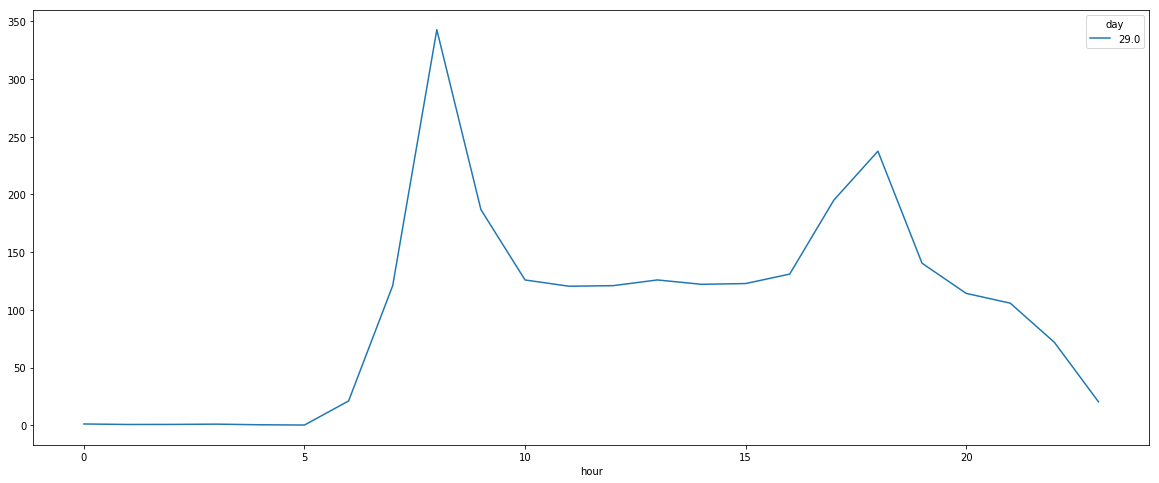

In [784]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)
(test.groupby(['hour','day']).outNums.mean()).unstack().plot()
plt.show()

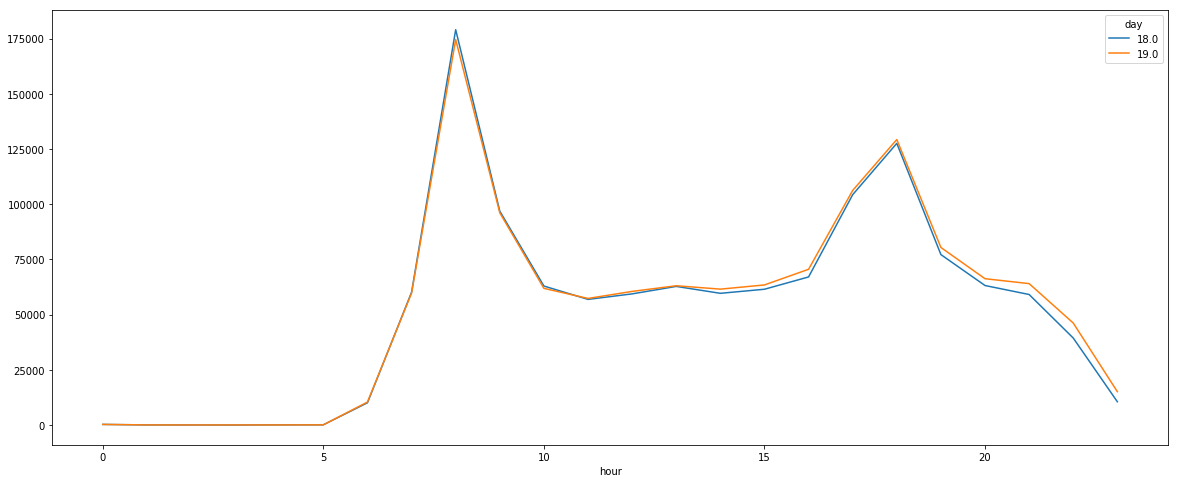

In [279]:
# 数据分析EDA
#stack简单说就是把columns转成index，unstack就是反过来
plt.rcParams['figure.figsize'] = (20.0, 8.0)
data[(data.day.isin([18,19]))].groupby(['hour', 'day']).outNums.sum().unstack().plot()
plt.show()

In [798]:
test['inNums'].sum()

0.0

In [778]:
test['inNums']=output1

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [795]:
valid['outNums'].sum()

1202647.0

In [796]:
valid_res_outNums.sum()

1229143.2734572021

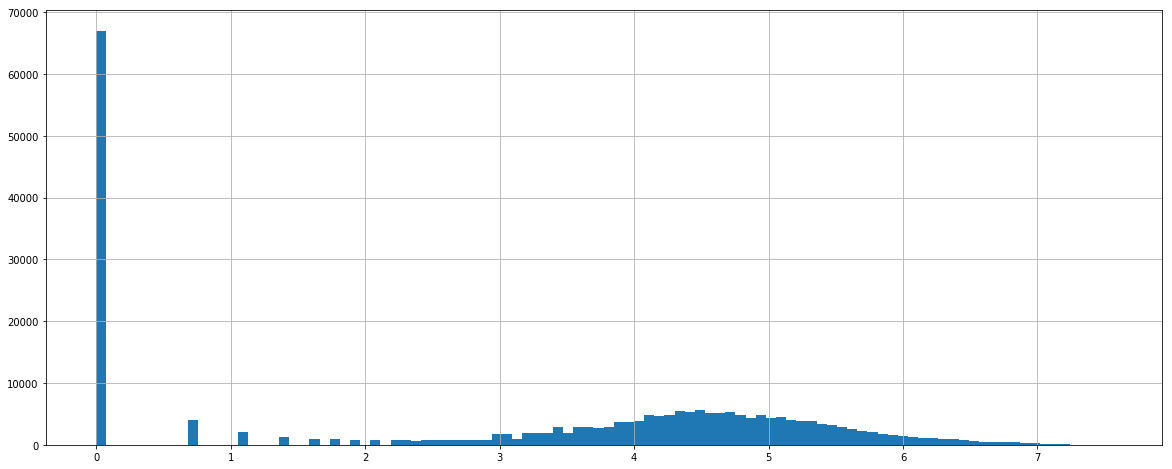

In [668]:
np.log1p(data['inNums']).hist(bins=100)

In [412]:
data.day.unique()

array([20,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 29],
      dtype=int64)

In [231]:
X_test.head()

,stationID,hour,minute,day,week,inNums_whm_max,inNums_whm_min,inNums_whm_mean,inNums_whm_median,outNums_whm_max,...,outNums_whm_median,inNums_wh_max,inNums_wh_min,inNums_wh_mean,inNums_wh_median,outNums_wh_max,outNums_wh_min,outNums_wh_mean,outNums_wh_median,inNums
0,0,0,0,29.0,2.0,0.0,0.0,0.0,0.0,3.0,...,1.5,0.0,0.0,0.0,0.0,3.0,0.0,0.25,0.0,0.227262
1,0,0,10,29.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.25,0.0,0.105688
2,0,0,20,29.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.25,0.0,0.101258
3,0,0,30,29.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.25,0.0,0.101184
4,0,0,40,29.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.25,0.0,0.088921


In [418]:
data_eda=data[data.day==20]

In [ ]:
def quantile_clip(group):
    group.plot()
    group[group < group.quantile(.05)] = group.quantile(.05)
    group[group > group.quantile(.95)] = group.quantile(.95)
    group.plot()
    plt.show()
    return group

data_eda.groupby(['stationID', 'day','hour','minute'])['inNums'].transform(quantile_clip)